# Investigate a Dataset
## Titanic Survival Exploration: What factors make a passenger more likely to survive?
### Load Dataset

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline

# Load the dataset
in_file = 'titanic_data.csv'
full_data = pd.read_csv(in_file)

# Print the first data entries
display(full_data.head())
outcomes = full_data['Survived']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


These are the features in the Titanic data:
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin** Cabin number of the passenger (Some entries contain `NaN`)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

Note: I used these descriptions and some code from the MLND Titantic project.

I will define a derived feature **person**, which is Child if a passenger is less than 10 years of age, and is otherwise equal to the Sex of the passenger.

In [51]:
def type_person(gender, age):
    if age < 10:
        return 'Child'
    elif gender=='female':
        return 'Woman';
    else:
        return 'Man';
full_data['person'] = map(type_person,full_data['Sex'],full_data['Age'])

In [37]:
def accuracy_score(truth, pred):
    """ Returns accuracy score for input truth and predictions. """
    
    # Ensure that the number of predictions matches number of outcomes
    if len(truth) == len(pred): 
        
        # Calculate and return the accuracy as a percent
        return "Predictions have an accuracy of {:.2f}%.".format((truth == pred).mean()*100)
    
    else:
        return "Number of predictions does not match number of outcomes!"

### Visualize Dataset and Make Predictions

Since the majority of passengers did not survive, I will initially predict that all passengers did not survive as a naive prediction.

In [44]:
def predictions_0(data):
    """ Model with no features. Always predicts a passenger did not survive. """

    predictions = []
    for _, passenger in full_data.iterrows():
        
        # Predict the survival of 'passenger'
        predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_0(full_data)

*Accuracy of predicting all passengers did not survive:*  

In [45]:
print accuracy_score(outcomes, predictions)

Predictions have an accuracy of 61.62%.


**Answer:** 61.62%.

#### Examine survival based on Sex

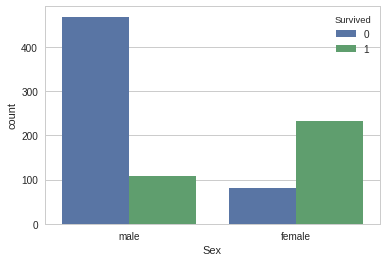

In [46]:
sns.set_style('whitegrid')
sns.countplot(x='Sex', hue='Survived',data=full_data)

This shows that more females survive than males. Now I will predict that if a passenger is female, she survived, and if a passenger is male he did not survive.

In [48]:
def predictions_1(data):
    """ Model with one feature: 
            - Predict a passenger survived if they are female. """
    
    predictions = []
    for _, passenger in full_data.iterrows():
        if passenger['Sex'] == 'female':
            predictions.append(1)
        else:
            predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_1(full_data)

In [49]:
print accuracy_score(outcomes, predictions)

Predictions have an accuracy of 78.68%.


#### Examine survival based on derived Person feature

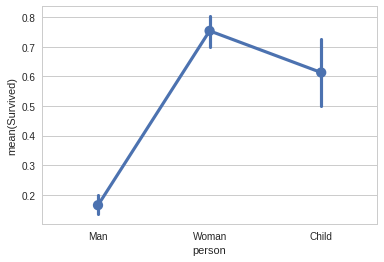

In [52]:
sns.set_style('whitegrid')
sns.pointplot(x='person', y='Survived',data=full_data)

This shows that women are the most likely type of Person to survive, and have about a 75% chance of survival. Men are the least likely to survive with about 15% chance of surviving. Children (passengers with an age less than 10) are also likely to survive, with a survival chance of 60%. So now I will predict that if a passenger is female, she survives, and then if he is a Child, he survives, otherwise he does not survive.

In [54]:
def predictions_2(data):
    predictions = []
    for _, passenger in full_data.iterrows():
        if passenger['Sex'] == 'female':
            predictions.append(1)
        elif passenger['Age'] < 10:
            predictions.append(1)
        else:
            predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_2(full_data)

In [55]:
print accuracy_score(outcomes, predictions)

Predictions have an accuracy of 79.35%.


#### Examine Pclass vs Survived

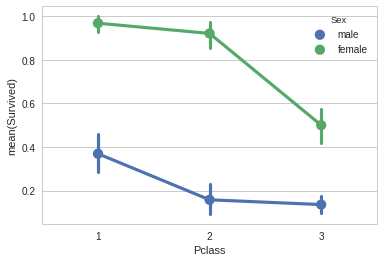

In [63]:
sns.set_style('whitegrid')
sns.pointplot(x='Pclass', y='Survived',hue='Sex',data=full_data)

This plot shows that passengers with a Pclass of 1 are more likely to survive, whereas passengers with a Plass of 3 are the least likely to survive. Again, females are more likely to survive for each Pclass. However, this won't improve the predictions for males since each Pclass still has less than 50% chance of surviving.

#### Examine survival based on Parch and Person

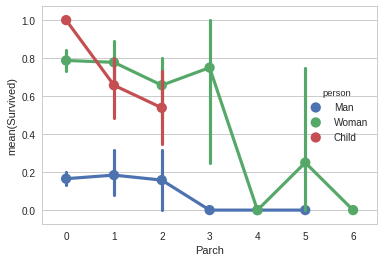

In [74]:
sns.set_style('whitegrid')
sns.pointplot(x='Parch', y='Survived',hue='person',data=full_data)

This plot shows that women and children who have less than or equal to 3 family members with them are more likely to survive. I will include this in the predictions.

In [79]:
def predictions_3(data):
    
    predictions = []
    for _, passenger in full_data.iterrows():
        if passenger['Parch'] <= 3 and passenger['Sex'] == 'female':
            predictions.append(1)
        elif passenger['Parch'] <= 3 and passenger['Age'] < 10:
            predictions.append(1)
        else:
            predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_3(full_data)

In [80]:
print accuracy_score(outcomes, predictions)

Predictions have an accuracy of 79.91%.


#### Examine survival based on Deck

Now I will try to improve the accuracy of the male passengers, instead of just predicting that all males do not survive. I will do this by defining a new feature **Deck**, that is the letter of the **Cabin** number.

In [105]:
def deck(cabin):
    return str(cabin)[0]
full_data['Deck'] = map(deck,full_data['Cabin'])

Survival based on deck for male passengers.

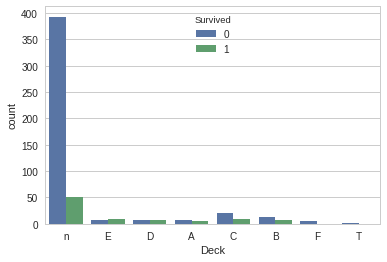

In [126]:
sns.set_style('whitegrid')
sns.countplot(x='Deck',hue='Survived',data=full_data[full_data['person']=='Man'])

Survival based on deck for female passengers.

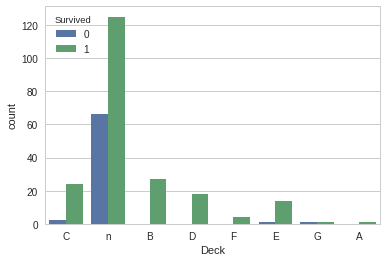

In [127]:
sns.set_style('whitegrid')
sns.countplot(x='Deck',hue='Survived',data=full_data[full_data['person']=='Woman'])

These two plots show that males on the E deck are more likely to survive, whereas there is no deck where females aren't less likely to survive. Now I will predict that males on the E deck survive.

In [128]:
def predictions_4(data):
    
    predictions = []
    for _, passenger in full_data.iterrows():
        if passenger['Parch'] <= 3 and passenger['Sex'] == 'female':
            predictions.append(1)
        elif passenger['Parch'] <= 3 and passenger['Age'] < 10:
            predictions.append(1)
        elif passenger['Deck'] == 'E':
            predictions.append(1)
        else:
            predictions.append(0)
    
    # Return our predictions
    return pd.Series(predictions)

# Make the predictions
predictions = predictions_4(full_data)

In [129]:
print accuracy_score(outcomes, predictions)

Predictions have an accuracy of 80.13%.


I have achieved a prediction accuracy of 80.13% by predicting that females or children who have less than or equal to three family members survive and males on the E deck survive. Otherwise, the passenger does not survive.